Using device: cuda


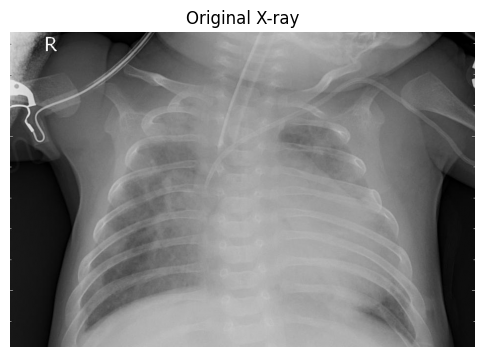

Predicted pathologies for person1_virus_6.jpeg
Atelectasis: 0.366
Consolidation: 0.514
Infiltration: 0.598
Pneumothorax: 0.228
Edema: 0.422
Emphysema: 0.500
Fibrosis: 0.270
Effusion: 0.247
Pneumonia: 0.650
Pleural_Thickening: 0.130
Cardiomegaly: 0.210
Nodule: 0.364
Mass: 0.501
Hernia: 0.016
Lung Lesion: 0.019
Fracture: 0.148
Lung Opacity: 0.854
Enlarged Cardiomediastinum: 0.536


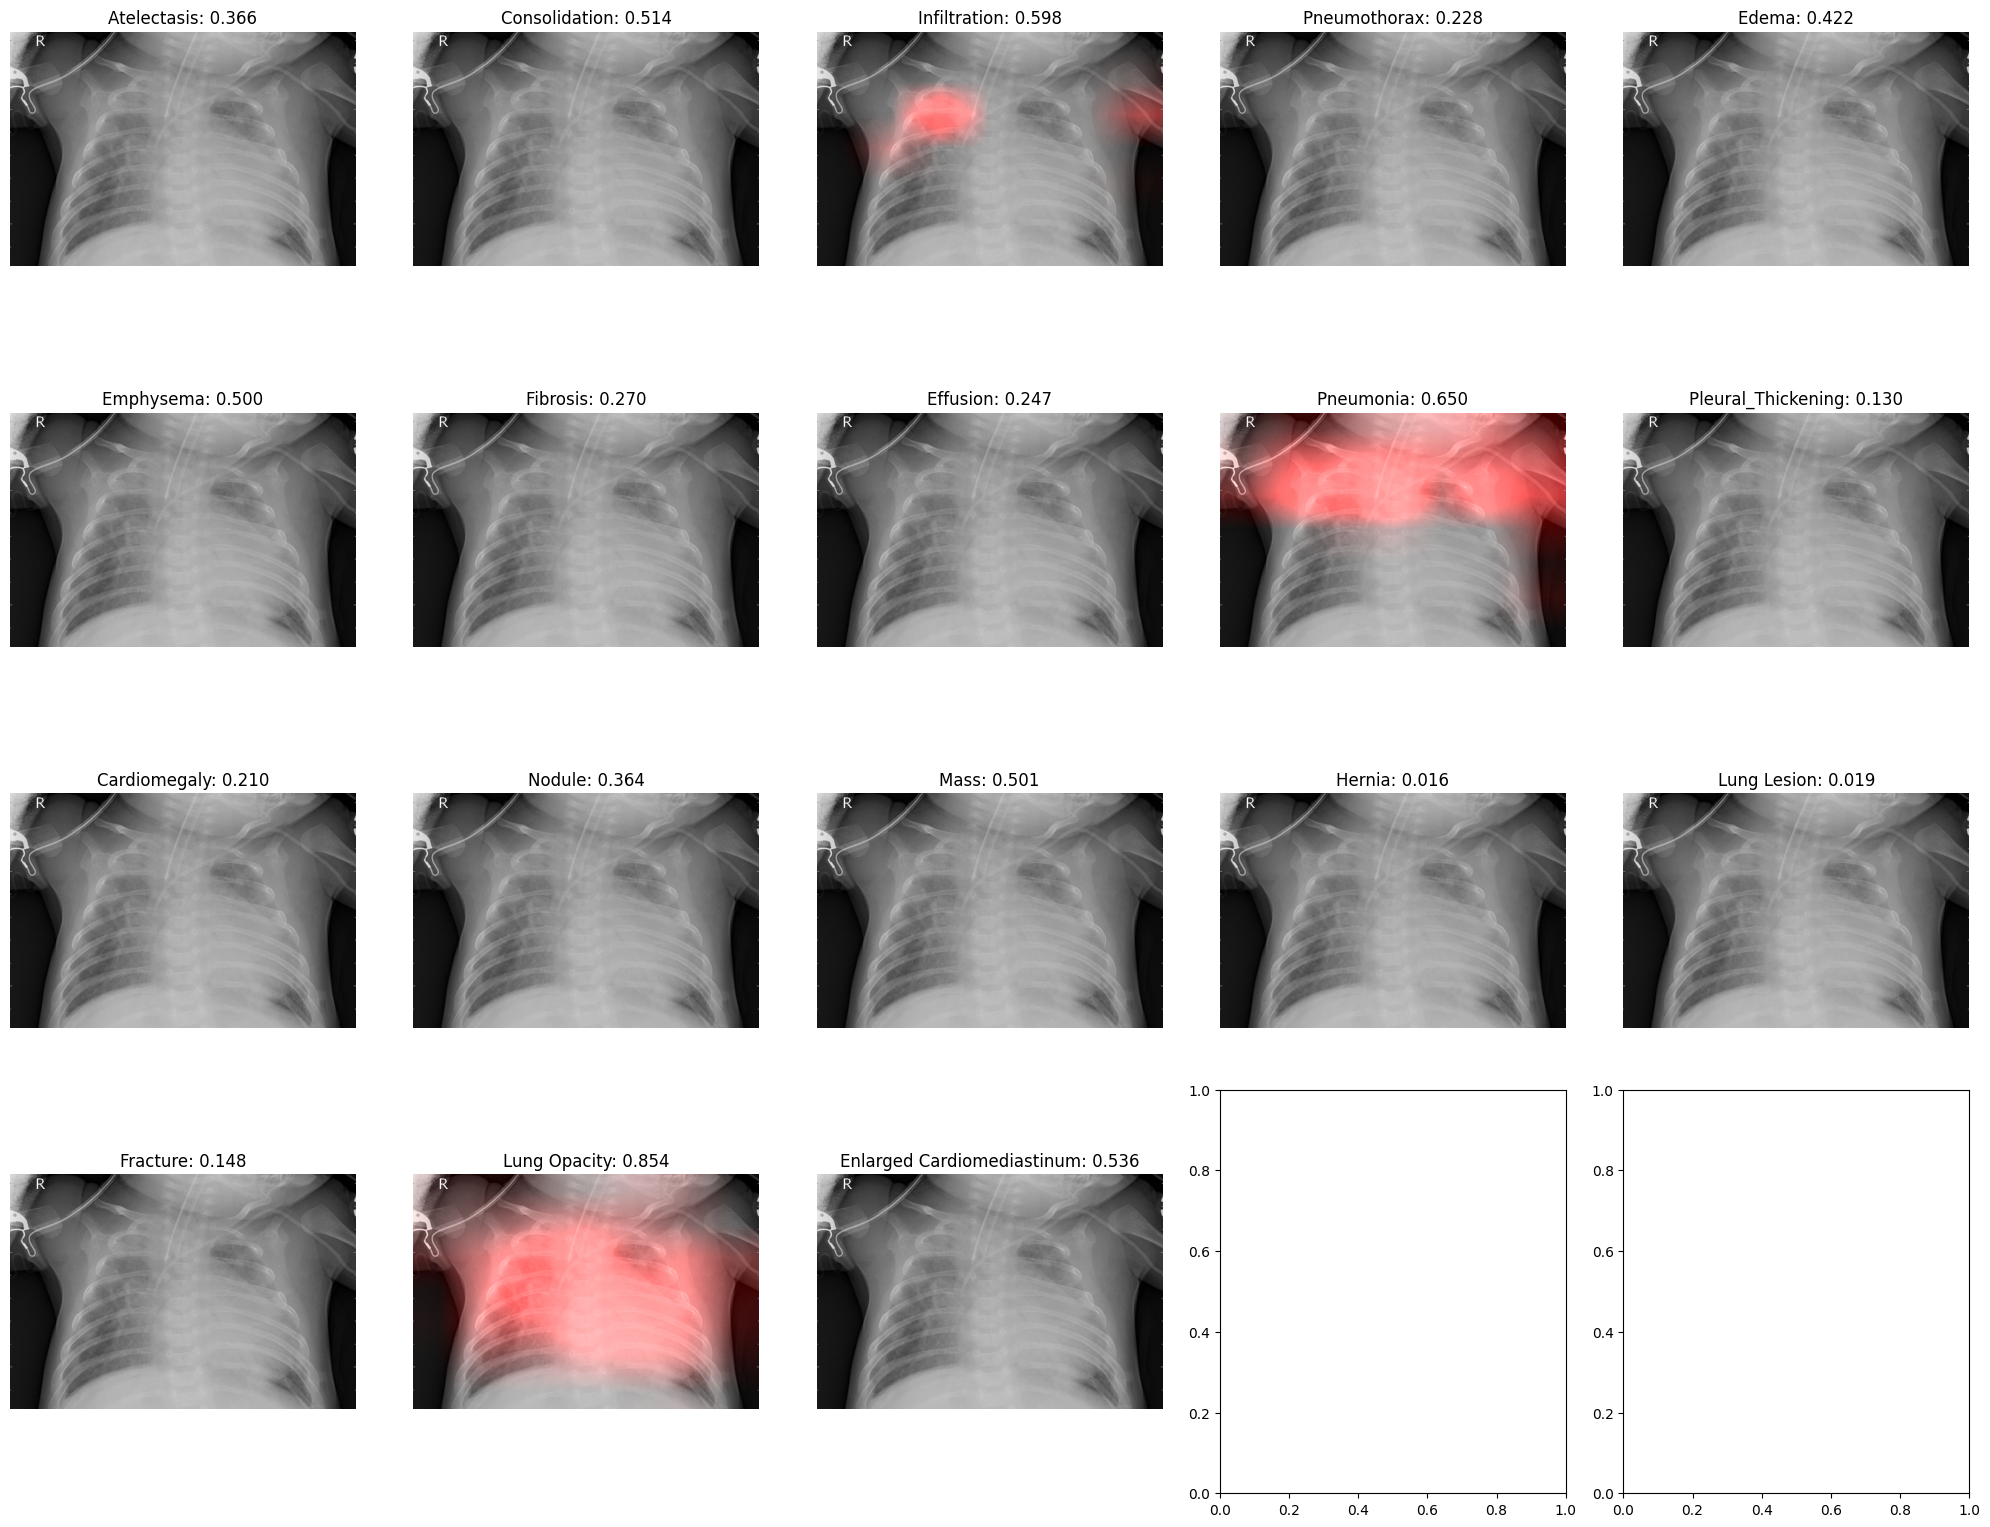

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchxrayvision as xrv
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the X-ray image
sample_dir = "./samples"
img_name = "person1_virus_6.jpeg"
img_path = os.path.join(sample_dir, img_name)

testing_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
H, W = testing_img.shape

# Show the original X-ray
plt.figure(figsize=(6,6))
plt.imshow(testing_img, cmap="gray")
plt.title("Original X-ray")
plt.axis('off')
plt.show()

# Prepare the image for the model: pad to square and resize to 224x224
size = max(H, W)
padded_img = np.zeros((size, size), dtype=testing_img.dtype)
start_h = (size - H) // 2
start_w = (size - W) // 2
padded_img[start_h:start_h+H, start_w:start_w+W] = testing_img
testing_img_resized = cv2.resize(padded_img, (224, 224), interpolation=cv2.INTER_AREA)

# Normalize and convert to tensor
img_tensor = xrv.datasets.normalize(testing_img_resized, maxval=255.0)
input_tensor = torch.tensor(img_tensor).unsqueeze(0).to(device)

# Load pre-trained DenseNet model
model = xrv.models.get_model("densenet121-res224-all").to(device)
model.eval()

# Grad-CAM class for generating heatmaps
class GradCAM:
    def __init__(self, model, target_layer, orig_size):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.orig_H, self.orig_W = orig_size
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def __call__(self, x, target_class):
        self.model.zero_grad()
        output = self.model(x)
        if isinstance(target_class, str):
            target_class = self.model.pathologies.index(target_class)
        score = output[0, target_class]
        score.backward()

        # Compute weighted combination of activations
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)

        # Resize to feature map size first (safe)
        cam = F.interpolate(cam, size=(self.activations.shape[2], self.activations.shape[3]),
                            mode='bilinear', align_corners=False)
        cam = cam[0,0].cpu().numpy()

        # Then resize heatmap to match original X-ray size
        cam_resized = cv2.resize(cam, (self.orig_W, self.orig_H), interpolation=cv2.INTER_LINEAR)
        cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min() + 1e-8)
        return cam_resized

# Initialize Grad-CAM with the last convolutional layer and original image size
target_layer = model.features[-1]
grad_cam = GradCAM(model, target_layer, orig_size=(H, W))

# Run inference to get pathology scores
with torch.no_grad():
    output = model(input_tensor)
scores = output[0].cpu().numpy()

print("Predicted pathologies for", img_name)
for label, score in zip(model.pathologies, scores):
    print(f"{label}: {score:.3f}")

# Generate Grad-CAM heatmaps for all pathologies
fig, axs = plt.subplots(4, 5, figsize=(20,16))
axs = axs.flatten()

for i, label in enumerate(model.pathologies):
    cam = grad_cam(input_tensor, label)
    overlay = cv2.cvtColor(testing_img, cv2.COLOR_GRAY2RGB)/255.0
    overlay[:, :, 0] += cam  # overlay heatmap on red channel
    overlay = np.clip(overlay, 0, 1)

    axs[i].imshow(overlay)
    axs[i].set_title(f"{label}: {scores[i]:.3f}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()
